Analysis of structural trends versus energy for all 2&times;2&times;2 symmetry inequivalent TiOF<sub>2</sub> supercells, using our set of cluster-expansion–predicted energies.

In [1]:
from pymatgen.io.vasp import Poscar
import pandas as pd
from polyhedral_analysis.configuration import Configuration
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe
from polyhedral_analysis.octahedral_analysis import opposite_vertex_pairs
from polyhedral_analysis.utils import flatten
from collections import Counter
from tqdm import tqdm_notebook
from scipy.stats import gaussian_kde
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing

In [2]:
import matplotlib.font_manager as fm
import matplotlib
import figure_formatting

matplotlib.rc('font', family='sans serif') 
# matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='true') 
# matplotlib.font_manager._rebuild()

In [3]:
recipe = PolyhedraRecipe( method='distance cutoff', 
                          coordination_cutoff=3.0, 
                          central_atoms='Ti',
                          vertex_atoms=['O','F'] )

In [4]:
# load all `bsym` generated poscars

In [5]:
class Config():
    
    def __init__(self, structure, config_id, energy):
        self.structure = structure
        self.config_id = config_id
        self.energy = energy
        self.config = Configuration( structure=structure, recipes=[recipe] )
        
    def non_f4o2(self):
        count = 0
        for p in self.config.polyhedra:
            coord_count = Counter([ v.label for v in p.vertices ])
            if coord_count['F'] != 4:
                count += 1
        return count
    
    def collinear_oxygen(self):
        count = 0
        for p in self.config.polyhedra:
            vertex_pairs = opposite_vertex_pairs( p, check=False )
            for vp in vertex_pairs:
                if set( [ vp[0].label, vp[1].label ] ) == {'O'}:
                    count += 1
        return count
    
    def bond_lengths(self):
        distances = { 'O': [], 'F': [] }
        for p in self.config.polyhedra:
            for d, l in p.vertex_distances( vertex_labels=True ):
                distances[l].append( d )
        return distances

In [7]:
energies = pd.read_csv('../cluster_predictions/energies.out', delim_whitespace=True, 
                       names=['config_id', 'energy', 'dft_energy'])
energies.sort_values('config_id', inplace=True )

In [8]:
configs = []
for i in tqdm_notebook(range(2664)):
    structure = Poscar.from_file('../2x2x2_configurations/poscars/config_{:04d}.poscar'.format( i ) ).structure
    energy = energies.iloc[i].energy
    configs.append( Config( structure, i, energy ) )

Plot the distribution of energies versus the number of collinear O–Ti–O units.

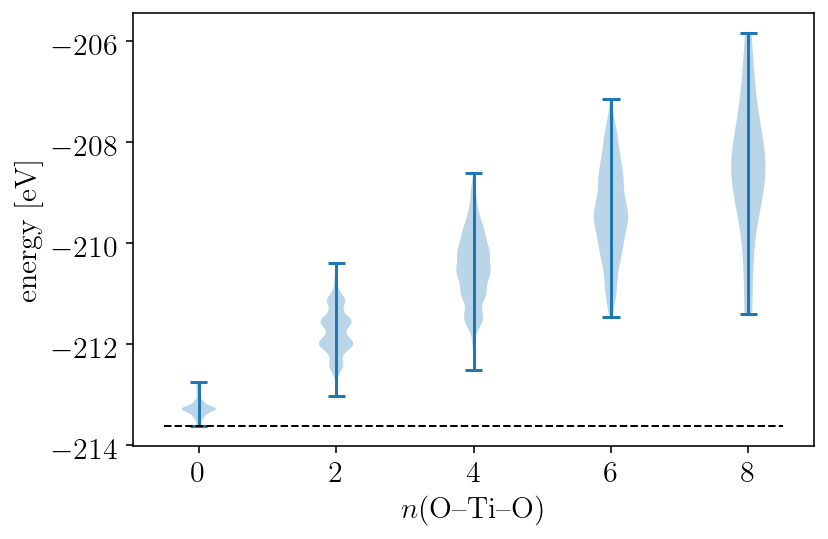

In [9]:
matplotlib.rc('font', size=15)
data = []
for nc in range(0,9,2):
    selected = [ c for c in configs if c.collinear_oxygen()==nc ]
    data.append( [c.energy for c in selected ] )
plt.violinplot(data, positions=list(range(0,9,2)) )
plt.hlines(min(flatten(data)),xmin=-0.5,xmax=8.5, lw=1, linestyles='--')
plt.xlabel(r'$n($O--Ti--O$)$')
plt.ylabel(r'energy [eV]')
plt.tight_layout()
plt.savefig('TiOF2_collinear_dist.pdf')
plt.show()

Plot the distribution of energies versus the number of Ti<i>X</i><sub>6</sub> octahedra where <i>X</i> is not 2O+4F.

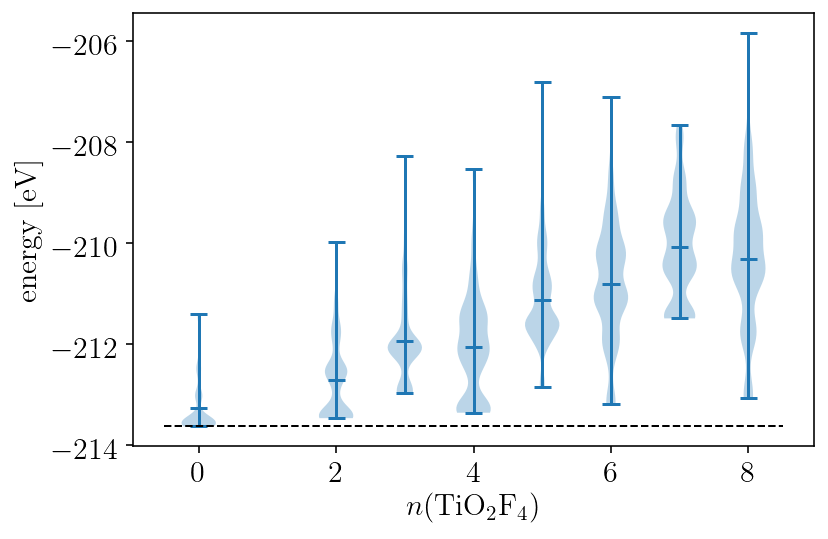

In [10]:
data = []
pos = []
for nc in range(0,9):
    selected = [ c for c in configs if c.non_f4o2()==nc ]
    this_data = [c.energy for c in selected ]
    if this_data:
        data.append( this_data )
        pos.append(nc)
plt.violinplot(data, positions=pos, showmeans=True, bw_method=0.25 )
plt.hlines(min(flatten(data)),xmin=-0.5,xmax=8.5, lw=1, linestyles='--')
plt.xlabel(r'$n($TiO$_2$F$_4$$)$')
plt.ylabel(r'energy [eV]')
plt.tight_layout()
plt.savefig('TiOF2_n_TiO2F4.pdf')
plt.show()
